Используемые ресурсы: \\
https://arxiv.org/pdf/1808.00158.pdf (статья) \\
https://github.com/mravanelli/SincNet/blob/master/dnn_models.py (оригинал) \\
https://github.com/theolepage/keras-sincnet/blob/master/keras_sincnet.ipynb (готовый пайплайн, который тут переписан) \\
https://stackoverflow.com/questions/66100195/a-tf-variable-created-inside-my-tf-function-has-been-garbage-collected (фикс пайплайна для одного из варианта имплементации кастомного слоя, описанного в статье) \\
https://www.tensorflow.org/datasets/catalog/librispeech (тут чуть лучше описан датасет, чем на сайте, куда он залит) \\
https://www.youtube.com/watch?v=mXQBObRGUgk (видос-пояснялка от автора)

In [1]:
!wget https://www.openslr.org/resources/12/train-clean-100.tar.gz
!tar xf train-clean-100.tar.gz

--2021-06-16 15:14:55--  https://www.openslr.org/resources/12/train-clean-100.tar.gz
Resolving www.openslr.org (www.openslr.org)... 46.101.158.64
Connecting to www.openslr.org (www.openslr.org)|46.101.158.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6387309499 (5.9G) [application/x-gzip]
Saving to: ‘train-clean-100.tar.gz’

train-clean-100.tar 100%[===================>]   5.95G  11.3MB/s    in 9m 47s  

2021-06-16 15:24:43 (10.4 MB/s) - ‘train-clean-100.tar.gz’ saved [6387309499/6387309499]



In [2]:
import math
from IPython.display import Audio
import soundfile as sf
import glob
import numpy as np
import matplotlib.pyplot as plt
Audio('/content/LibriSpeech/train-clean-100/103/1241/103-1241-0000.flac')

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Layer
from tensorflow.keras import backend as K

import numpy as np

In [4]:
from tensorflow.keras.utils import Sequence
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import soundfile as sf

In [5]:
import os
sample_frequency = 16000 # 16kHz (LibriSpeech)
frame_size = 0.200       # 200ms
frame_stride = 0.01      # 10ms

frame_length = int(round(frame_size * sample_frequency))
frame_step = int(round(frame_stride * sample_frequency))

batch_size = 128
dirname = '/content/LibriSpeech/train-clean-100'

In [6]:
# Ограничим датасет в 100 спикеров, для каждого будет взято по 10 записей
# и из каждой записи будет сделано 10 фреймов (иначе ну очень долго ждать)
max_speakers=100
max_utterances=10
max_num_frames = 10

In [7]:
X=[]
y=[]
for speaker_id, speaker in enumerate(os.listdir(dirname)):
    if (speaker_id == max_speakers):
      break
    speaker_path = os.path.join(dirname, speaker)
    speaker_chapters = os.listdir(speaker_path)

    for chapter in speaker_chapters:
        chapter_path = os.path.join(speaker_path, chapter)

        chapter_utterances = os.listdir(chapter_path)

        for utterance_id, utterance in enumerate(chapter_utterances):
            if (utterance_id == max_utterances):
              break
            utterance_path = os.path.join(chapter_path, utterance)

            if (not utterance.endswith('.txt')):              
              signal, _ = sf.read(utterance_path)
              signal_length = len(signal)
              num_frames = int(np.floor((signal_length - frame_length) / frame_step))
              num_frames = min(num_frames, max_num_frames)
              
              frames = np.arange(0, num_frames * frame_step, frame_step)

              for frame in frames:
                  X.append([utterance_path, frame])
                  y.append(speaker_id)

In [8]:
class LibrispeechGenerator(Sequence) :
  
    def __init__(self, X, y, batch_size):
        self.X = X
        self.y = y
        self.batch_size = batch_size

    def __len__(self):
        nb_batches = len(self.y) / float(self.batch_size)
        return np.ceil(nb_batches).astype(np.int)
    
    def __getitem__(self, batch_id):
        '''
        В пайплайне, который на керасе, тут был велосипед, такой что
        если batch_size больше оставшегося количества сэмплов, то они забивались
        другими случайными. В этом коде просто батч обрезается на последнем элементе
        '''
        batch_len = len(self.X[batch_id*self.batch_size:(batch_id+1)*self.batch_size])

        X_batch = np.zeros((batch_len, frame_length, 1))
        y_batch = np.zeros(batch_len)

        for i in range(batch_len):
            id = batch_id * batch_len + i

            path, frame = self.X[id]
            signal, fs = sf.read(path)

            X_batch[i, :, 0] = signal[frame:frame+frame_length]
            y_batch[i] = self.y[id]

        return X_batch, y_batch

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [10]:
train_gen = LibrispeechGenerator(X_train, y_train, batch_size)
val_gen = LibrispeechGenerator(X_val, y_val, batch_size)

In [11]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU, Flatten, LayerNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import ModelCheckpoint

In [12]:
class SincConv(Layer):
    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq,
                 stride=1, padding="VALID", min_low_hz=50, min_band_hz=50,
                 **kwargs):
        super(SincConv, self).__init__(**kwargs)

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq

        # Изменил initializer на описанный в статье
        self.b1 = self.add_weight(
            name='b1',
            shape=(self.nb_filters,),
            initializer=tf.keras.initializers.GlorotNormal(),
            trainable=True)
        self.band = self.add_weight(
            name='band',
            shape=(self.nb_filters,),
            initializer=tf.keras.initializers.GlorotNormal(),
            trainable=True)
        
        # Initialize weights with cutoff frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(50)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2)
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters)
        hz_points = self.mel_to_hz(mel_points)
        
        # Вот тут я не понял и не нашел зачем тут нужен np.roll
        #######################
        b1 = np.roll(hz_points, 1)
        b1[0] = 30
        b2 = np.roll(hz_points, -1)
        b2[-1] = (self.sample_freq / 2) - 100
        #######################

        self.set_weights([b1 / self.sample_freq, (b2 - b1) / self.sample_freq])
        min_freq = 50.0
        min_band = 50.0
        self.beg_freq = K.abs(self.b1) + min_freq / self.sample_freq
        self.end_freq = self.beg_freq + (K.abs(self.band) + min_band / self.sample_freq)
        
        t_right_linspace = np.linspace(1, (self.kernel_size - 1) / 2, int((self.kernel_size - 1) / 2))
        self.t_right = K.variable(t_right_linspace / self.sample_freq)

        n = np.linspace(0, self.kernel_size, num=self.kernel_size)
        window = 0.54 - 0.46 * K.cos(2 * np.pi * n / self.kernel_size)
        self.window = K.cast(window, "float32")

    def call(self, X):
        filters = []
        for i in range(self.nb_filters):
            low_pass1 = 2 * self.beg_freq[i] * sinc(self.beg_freq[i] * self.sample_freq, self.t_right)
            low_pass2 = 2 * self.end_freq[i] * sinc(self.end_freq[i] * self.sample_freq, self.t_right)
            band_pass = low_pass2 - low_pass1
            band_pass = band_pass / K.max(band_pass)

            filters.append(band_pass * self.window)

        filters = K.stack(filters)

        # TF convolution assumes data is stored as NWC
        filters = K.transpose(filters)
        filters = K.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return K.conv1d(X, filters)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)

v = K.variable(K.ones(1))
def sinc(band, t_right):
    y_right = K.sin(2 * math.pi * band * t_right) / (2 * math.pi * band * t_right)
    y_left = K.reverse(y_right, 0)
    y = K.concatenate([y_left, v, y_right])
    return y

In [13]:
def create_sincnet():
    model = Sequential()

    model.add(SincConv(80, 251, sample_frequency, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(max_speakers, activation='softmax'))

    return model

sincnet_model = create_sincnet()

Я не смог забороть warning: \\
WARNING:tensorflow:Gradients do not exist for variables ['b1:0', 'band:0'] when minimizing the loss. \\
тем не менее, сетка обучается


In [14]:
# В статье используется /lambda вместо /rho насколько я понял, 
# /epsilon стандартный совпадает с описаным в статье. 
sincnet_model.compile(optimizer=RMSprop(lr=0.001, rho = 0.95),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history_sinc = sincnet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=20)                           

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
142/142 [==============================] - 152s 694ms/step - loss: 3.3277 - accuracy: 0.1676 - val_loss: 3.7955 - val_accuracy: 0.1168
Epoch 2/20
142/142 [==============================] - 93s 656ms/step - loss: 2.4485 - accuracy: 0.3148 - val_loss: 2.6121 - val_accuracy: 0.2763
Epoch 3/20
142/142 [==============================] - 92s 651ms/step - loss: 1.9834 - accuracy: 0.4239 - val_loss: 2.8395 - val_accuracy: 0.2374
Epoch 4/20
142/142 [==============================] - 91s 638ms/step - loss: 1.6887 - accuracy: 0.4986 - val_loss: 2.3451 - val_accuracy: 0.3493
Epoch 5/20
142/142 [==============================] - 90s 636ms/step - loss: 1.4480 - accuracy: 0.5619 - val_loss: 2.0153 - val_accuracy: 0.4436
Epoch 6/20
142/142 [==============================] - 90s 636ms/step - loss: 1.2364 - accuracy: 0.6210 - val_loss: 1.7725 - val_accuracy: 0.4653
Epoch 7/20
142/142 [==============================] - 91s 639ms/step - loss: 1.1088 - accuracy: 0.6626 - val_loss: 1.6405 - val_a

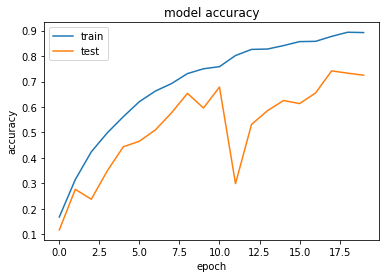

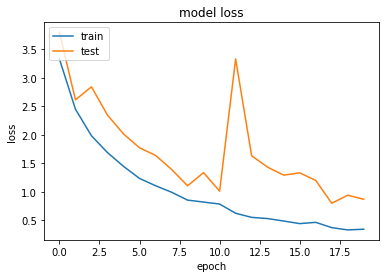

In [24]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history_sinc.history['accuracy'])
plt.plot(history_sinc.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_sinc.history['loss'])
plt.plot(history_sinc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
def create_net(enable_sincconv=True):
    model = Sequential()

    model.add(Conv1D(filters=64, kernel_size=251, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(max_speakers, activation='softmax'))

    return model

net_model = create_net()

In [16]:
# В статье используется /lambda вместо /rho насколько я понял, 
# /epsilon стандартный совпадает с описаным в статье. 
net_model.compile(optimizer=RMSprop(lr=0.001, rho = 0.95),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history_net = net_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=20)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
142/142 [==============================] - 91s 619ms/step - loss: 3.5234 - accuracy: 0.1601 - val_loss: 4.5895 - val_accuracy: 0.1854
Epoch 2/20
142/142 [==============================] - 88s 621ms/step - loss: 2.1944 - accuracy: 0.4017 - val_loss: 4.5478 - val_accuracy: 0.1856
Epoch 3/20
142/142 [==============================] - 87s 614ms/step - loss: 1.4931 - accuracy: 0.5689 - val_loss: 3.3202 - val_accuracy: 0.2989
Epoch 4/20
142/142 [==============================] - 87s 609ms/step - loss: 1.0788 - accuracy: 0.6831 - val_loss: 3.2615 - val_accuracy: 0.3869
Epoch 5/20
142/142 [==============================] - 86s 609ms/step - loss: 0.7804 - accuracy: 0.7764 - val_loss: 1.5205 - val_accuracy: 0.5447
Epoch 6/20
142/142 [==============================] - 88s 619ms/step - loss: 0.5762 - accuracy: 0.8350 - val_loss: 2.3332 - val_accuracy: 0.4392
Epoch 7/20
142/142 [==============================] - 86s 605ms/step - loss: 0.4507 - accuracy: 0.8681 - val_loss: 2.5256 - val_ac

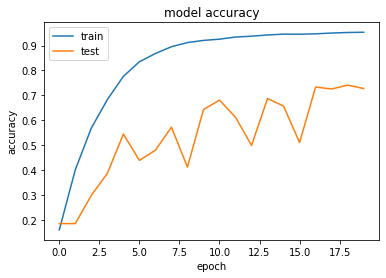

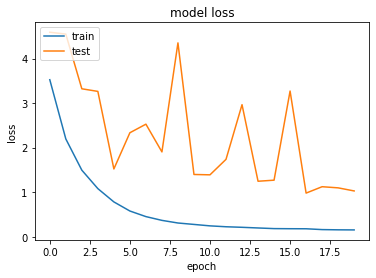

In [22]:
# summarize history for accuracy
plt.plot(history_net.history['accuracy'])
plt.plot(history_net.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_net.history['loss'])
plt.plot(history_net.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [17]:
class SincConvFast(Layer):

    @staticmethod
    def hz_to_mel(hz):
        return 2595.0 * np.log10(1.0 + hz / 700.0)

    @staticmethod
    def mel_to_hz(mels):
        return 700.0 * (10.0 ** (mels / 2595.0) - 1.0)

    def __init__(self, nb_filters, kernel_size, sample_freq,
                 stride=1, padding="VALID", min_low_hz=50, min_band_hz=50,
                 **kwargs):
        super(SincConvFast, self).__init__(**kwargs)

        self.nb_filters = nb_filters
        self.kernel_size = kernel_size
        self.sample_freq = sample_freq
        self.stride = stride
        self.padding = padding
        self.min_low_hz = min_low_hz
        self.min_band_hz = min_band_hz

        # Force filter size to be odd for later optimizations with symmetry
        if kernel_size % 2 == 0:
            self.kernel_size = self.kernel_size + 1

        # Set trainable parameters
        self.low_hz = self.add_weight(
            name='low_hz',
            shape=(self.nb_filters,),
            initializer=tf.keras.initializers.GlorotNormal(),
            trainable=True)
        self.band_hz = self.add_weight(
            name='band_hz',
            shape=(self.nb_filters,),
            initializer=tf.keras.initializers.GlorotNormal(),
            trainable=True)
        
        # Initialize weights with frequencies of the mel-scale filter-bank
        low_freq_mel = self.hz_to_mel(30)
        high_freq_mel = self.hz_to_mel(self.sample_freq / 2 - (self.min_low_hz + self.min_band_hz))
        mel_points = np.linspace(low_freq_mel, high_freq_mel, num=self.nb_filters + 1)
        hz_points = self.mel_to_hz(mel_points)
        self.set_weights([hz_points[:-1], np.diff(hz_points)])
      
        # Determine half of t
        t_linspace = np.arange(-(self.kernel_size - 1) / 2, 0)
        t = tf.Variable(2 * np.pi * t_linspace / self.sample_freq)
        t = tf.cast(t, "float32")
        self.t = tf.reshape(t, (1, -1))

        # Determine half of the hamming window
        n = np.linspace(0, (self.kernel_size / 2) - 1, num=int((self.kernel_size / 2)))
        window = 0.54 - 0.46 * tf.cos(2 * np.pi * n / self.kernel_size)
        window = tf.cast(window, "float32")
        self.window = tf.Variable(window)

    def call(self, X):
        low = self.min_low_hz + tf.abs(self.low_hz)
        high = tf.clip_by_value(low + self.min_band_hz + tf.abs(self.band_hz), self.min_low_hz, self.sample_freq / 2)
        band = high - low

        low_times_t = tf.linalg.matmul(tf.reshape(low, (-1, 1)), self.t)
        high_times_t = tf.linalg.matmul(tf.reshape(high, (-1, 1)), self.t)

        band_pass_left = ((tf.sin(high_times_t) - tf.sin(low_times_t)) / (self.t / 2)) * self.window
        band_pass_center = tf.reshape(2 * band, (-1, 1))
        band_pass_right = tf.reverse(band_pass_left, [1])

        filters = tf.concat([band_pass_left,
                             band_pass_center,
                             band_pass_right], axis=1)
        filters = filters / (2 * band[:, None])

        # TF convolution assumes data is stored as NWC
        filters = tf.transpose(filters)
        filters = tf.reshape(filters, (self.kernel_size, 1, self.nb_filters))

        return tf.nn.conv1d(X, filters, self.stride, self.padding)

    def compute_output_shape(self, input_shape):
        out_width_size = conv_utils.conv_output_length(
            input_shape[1],
            self.kernel_size,
            padding="valid",
            stride=1,
            dilation=1)
        return (input_shape[0], out_width_size, self.nb_filters)

In [19]:
def create_fastsincnet():
    model = Sequential()

    model.add(SincConvFast(80, 251, sample_frequency, input_shape=(frame_length, 1)))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Conv1D(filters=60, kernel_size=5))
    model.add(MaxPooling1D(pool_size=3))
    model.add(LayerNormalization())
    model.add(LeakyReLU(alpha=0.2))

    model.add(Flatten())
    model.add(LayerNormalization())

    model.add(Dense(1024))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(512))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(256))
    model.add(BatchNormalization(momentum=0.05))
    model.add(LeakyReLU(alpha=0.2))

    model.add(Dense(max_speakers, activation='softmax'))

    return model

fastsincnet_model = create_fastsincnet()

In [20]:
# В статье используется /lambda вместо /rho насколько я понял, 
# /epsilon стандартный совпадает с описаным в статье. 
fastsincnet_model.compile(optimizer=RMSprop(lr=0.001, rho = 0.95),
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])

history_fastsincnet = fastsincnet_model.fit(train_gen,
                            validation_data=val_gen,
                            epochs=20)    

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/20
142/142 [==============================] - 89s 605ms/step - loss: 1.9018 - accuracy: 0.5439 - val_loss: 1.0226 - val_accuracy: 0.7243
Epoch 2/20
142/142 [==============================] - 82s 580ms/step - loss: 0.5235 - accuracy: 0.8710 - val_loss: 0.8262 - val_accuracy: 0.7551
Epoch 3/20
142/142 [==============================] - 83s 583ms/step - loss: 0.2411 - accuracy: 0.9375 - val_loss: 1.0025 - val_accuracy: 0.7285
Epoch 4/20
142/142 [==============================] - 83s 584ms/step - loss: 0.1910 - accuracy: 0.9468 - val_loss: 0.4958 - val_accuracy: 0.8447
Epoch 5/20
142/142 [==============================] - 83s 583ms/step - loss: 0.1543 - accuracy: 0.9550 - val_loss: 0.4107 - val_accuracy: 0.8706
Epoch 6/20
142/142 [==============================] - 83s 582ms/step - loss: 0.1417 - accuracy: 0.9586 - val_loss: 0.4872 - val_accuracy: 0.8504
Epoch 7/20
142/142 [==============================] - 83s 582ms/step - loss: 0.1241 - accuracy: 0.9624 - val_loss: 0.5492 - val_ac

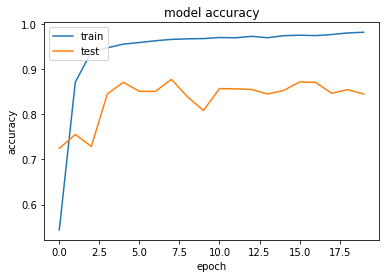

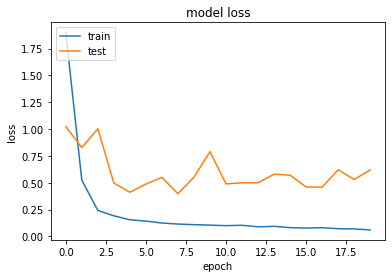

In [23]:
# summarize history for accuracy
plt.plot(history_fastsincnet.history['accuracy'])
plt.plot(history_fastsincnet.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history_fastsincnet.history['loss'])
plt.plot(history_fastsincnet.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

а) Какая задача решалась?

Решалась проблема распознования чтецов. Есть некоторое количество чтецов, есть их записанный голос озвучивания. Затем по записи надо определить какому именно чтецу какая запись принадлежит.

б) В чём основная идея метода и в чём её отличие от других решений? Пишите своими словами.

Идея состоит в создании кастомного первого сверточного слоя. Как показано в статье, обычный сверточный слой вначале выдает тяжело интерпретируемые фильтры. Возможным решением данной проблемы является задаваемая формая фильтров, которые обучаются в первом сверточном слое. Так, для каждого фильтра обучается только для параметра: f1 и f2 - cut-off frequencies. А еще из-за того что новый фильтр получается симметричный есть буст по времени для этого слоя. 

в) Какой эксперимент ставился? Какие получились результаты и как их можно интерпретировать?

Сравнивались три сетки: одна с кастомным слоем, с быстрой реализацией кастомного слоя и одна с обычной CNN. В статье использовалась метрика Frame Error Rate (я не нашел как работает эта метрика). В пайплайне этого ноутбука использовалась accuracy. Вариант с быстрым кастомным слоем начинает быстрее сходится и требует меньше времени. Варианты с обычным кастомным слоем и обычный сверткой требуют примерно одинаково времени и сходятся практически одинаково (чето мне подсказывает что в реализации обычного кастомного слоя баг связанный с warning'ом, но я не нашел). 

г) Как можно использовать полученный результат? Удалось ли приблизиться к цифрам из статьи? Какие есть перспективы для развития?

- Как можно использовать полученный результат? \\
Использовать обученную сетку (?)
- Удалось ли приблизиться к цифрам из статьи? \\
Использовалась другая метрика, поэтому сказать нельзя.
- Какие есть перспективы для развития?  \\
В статье описывается как используются MFCC и FBANK'и, так что вариант с другим видом входных данных уходит. Можно посмотреть на то, как выглядит фильтры во внутреннях слоях и попробывать заменить их на кастомный. Именно в этом пайплайне следует еще применить one-hot-encoding.  


**Часть 2** \\
Я сейчас пишу бакалаврскую, которая связана с детекцией. Нашел прикольную статью https://arxiv.org/pdf/2102.04306.pdf , понравилась она мне только по той причине, что там fancy stuff в виде трансформеров, что является относительно новой идеей в применении в CV. Эксперимент по ней еще не ставил, но планирую применить в бакалаврской. А еще я писал UNet в рамках Deep Learning School и было бы прикольно ее еще как-то разбавить трансформерами да и разобраться в самих трансформерах.